# Initial Setup

In [1]:
from datetime import datetime as dt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import statistics as stats
from matplotlib import pyplot as plt
from hmmlearn import hmm
from utils import *
%matplotlib inline

Using TensorFlow backend.


In [2]:
#set up matplotlib
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (30, 15),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)

# constants
MOVING_AVERAGE_WINDOW_SIZE = 30
PREDICTION_WINDOW_SIZE = 50
EPOCH = 100
BATCH_SIZE = 30
LSTM_UNITS = 60
DROPOUT = 0.2
NUM_LSTM_LAYERS = 4

# Utility Functions

In [3]:
def show_graph(data):
    plt.plot(data['DCOILWTICO'])
    plt.xlabel('Date')
    plt.ylabel('Oil Prices')
    plt.title('Trend of Crude Oil Prices')
    plt.show()
     
def get_trend(data):
    return [data[i - 1] < data[i] for i in range(1, len(data))]

def get_moving_averages(data, window_size):
    return [stats.mean(data[i: i + window_size]) for i in range(len(data) - window_size)]

def split_to_prediction_windows(data, prediction_window):
    x = []
    y = []
    for i in range(prediction_window, len(data)):
        x.append(data[i - prediction_window: i, :])
        y.append(data[i, 0])
    return np.array(x), np.array(y)

def generate_train_test_prediction_windows(train, test, prediction_window_size):
    x_train, y_train = split_to_prediction_windows(train, prediction_window_size)
    x_test, y_test = split_to_prediction_windows(test, prediction_window_size)
    return x_train, y_train, x_test, y_test

# Data Cleaning and Merging of Datasets by Date

In [4]:
oil_prices = pd.read_csv('oil_prices.csv', index_col='DATE', parse_dates=['DATE'], date_parser=lambda date: dt.strptime(date,'%d/%m/%Y').date())
oil_prices = oil_prices[oil_prices['DCOILWTICO'] != '.']
oil_prices['DCOILWTICO'] = pd.to_numeric(oil_prices['DCOILWTICO'])
oil_prices.head()

,DCOILWTICO
DATE,
1986-01-02,25.56
1986-01-03,26.00
1986-01-06,26.53
1986-01-07,25.85
1986-01-08,25.87


In [5]:
djia = pd.read_csv('djia.csv', index_col='Date', parse_dates=['Date'], date_parser=lambda date: dt.strptime(date,'%d/%m/%Y').date())
djia = djia[(djia['Open'] < 60000) & (djia['Open'] > 0) & (djia['High'] > djia['Low'])]
djia.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1985-01-29,1277.719971,1295.489990,1266.890015,1292.619995,1292.619995,13560000
1985-01-30,1297.369995,1305.099976,1278.930054,1287.880005,1287.880005,16820000
1985-01-31,1283.239990,1293.400024,1272.640015,1286.770020,1286.770020,14070000
1985-02-01,1276.939941,1286.109985,1269.770020,1277.719971,1277.719971,10980000
1985-02-04,1272.079956,1294.939941,1268.989990,1290.079956,1290.079956,11630000


In [6]:
oil_prices = oil_prices.join(djia, how='inner').drop(['Open', 'Adj Close'], axis=1)
oil_prices.head()

,DCOILWTICO,High,Low,Close,Volume
1986-01-02,25.56,1551.949951,1523.739990,1537.729980,10660000
1986-01-03,26.00,1557.109985,1534.979980,1549.199951,10460000
1986-01-06,26.53,1557.000000,1537.040039,1547.589966,11000000
1986-01-07,25.85,1573.739990,1544.500000,1565.709961,15170000
1986-01-08,25.87,1578.099976,1516.630005,1526.609985,20630000


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


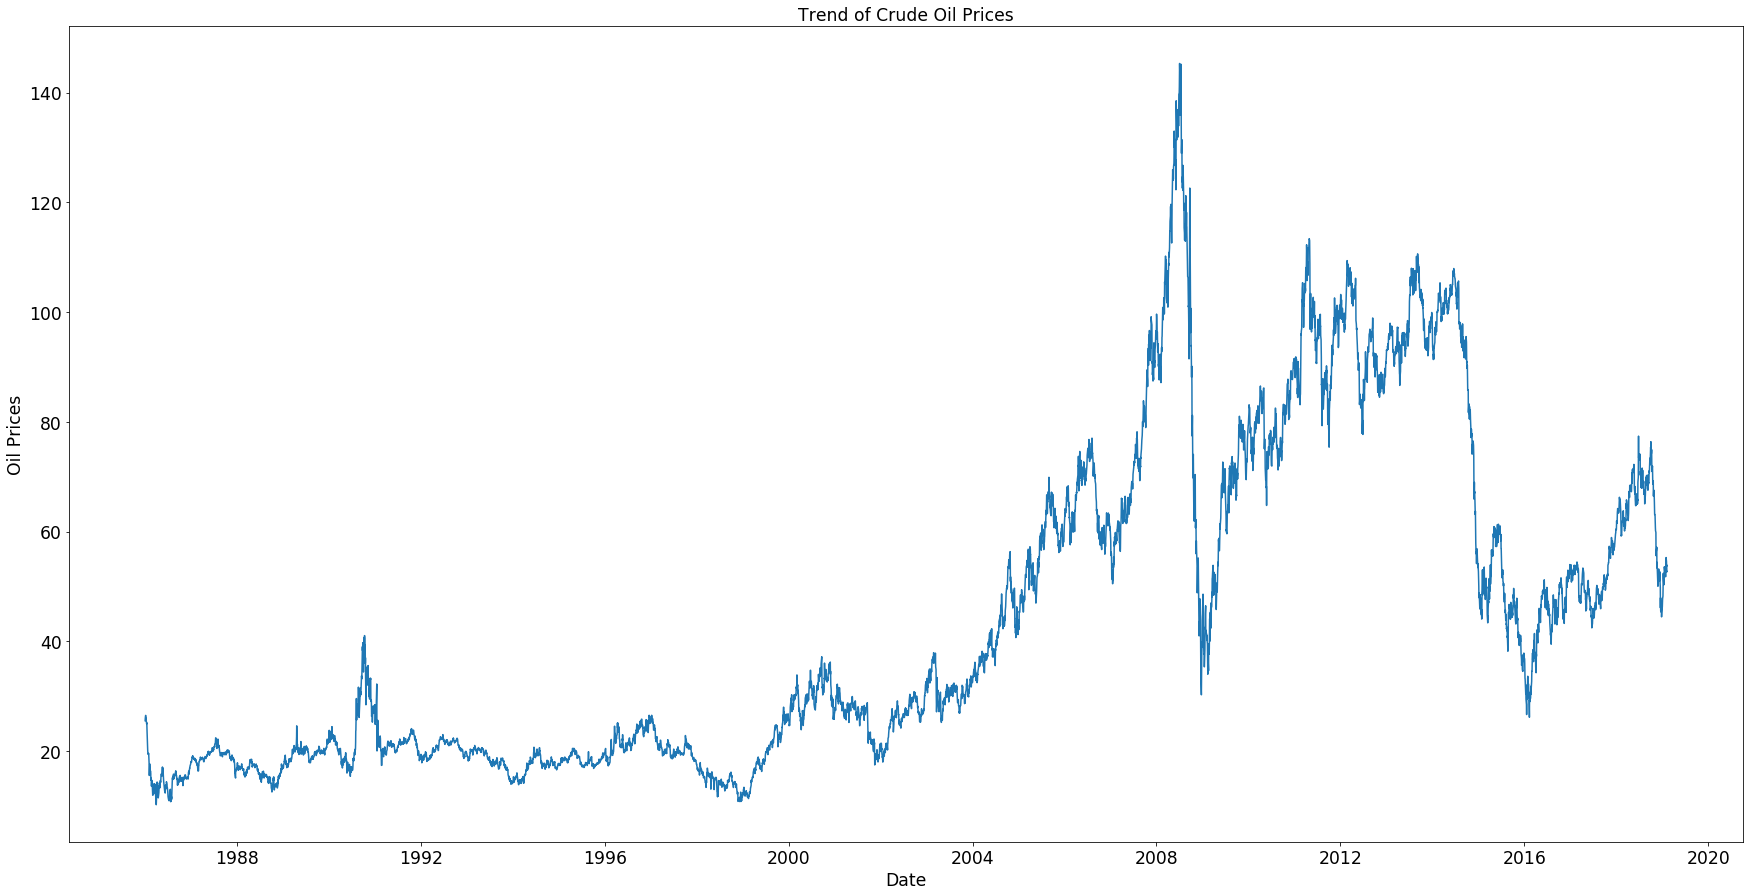

In [7]:
show_graph(oil_prices)

In [8]:
averages, trends = get_moving_window_dataframes(oil_prices, MOVING_AVERAGE_WINDOW_SIZE)

In [9]:
averages.head()

,DCOILWTICO,High,Low,Close,Volume
0,21.076667,1571.169320,1540.901998,1558.276330,1.521833e+07
1,20.759000,1575.060653,1544.647998,1562.500329,1.549967e+07
2,20.382333,1579.341988,1548.463000,1566.819665,1.571533e+07
3,20.000667,1583.749321,1552.262667,1570.508667,1.585467e+07
4,19.610000,1587.139986,1555.511666,1574.079000,1.581267e+07


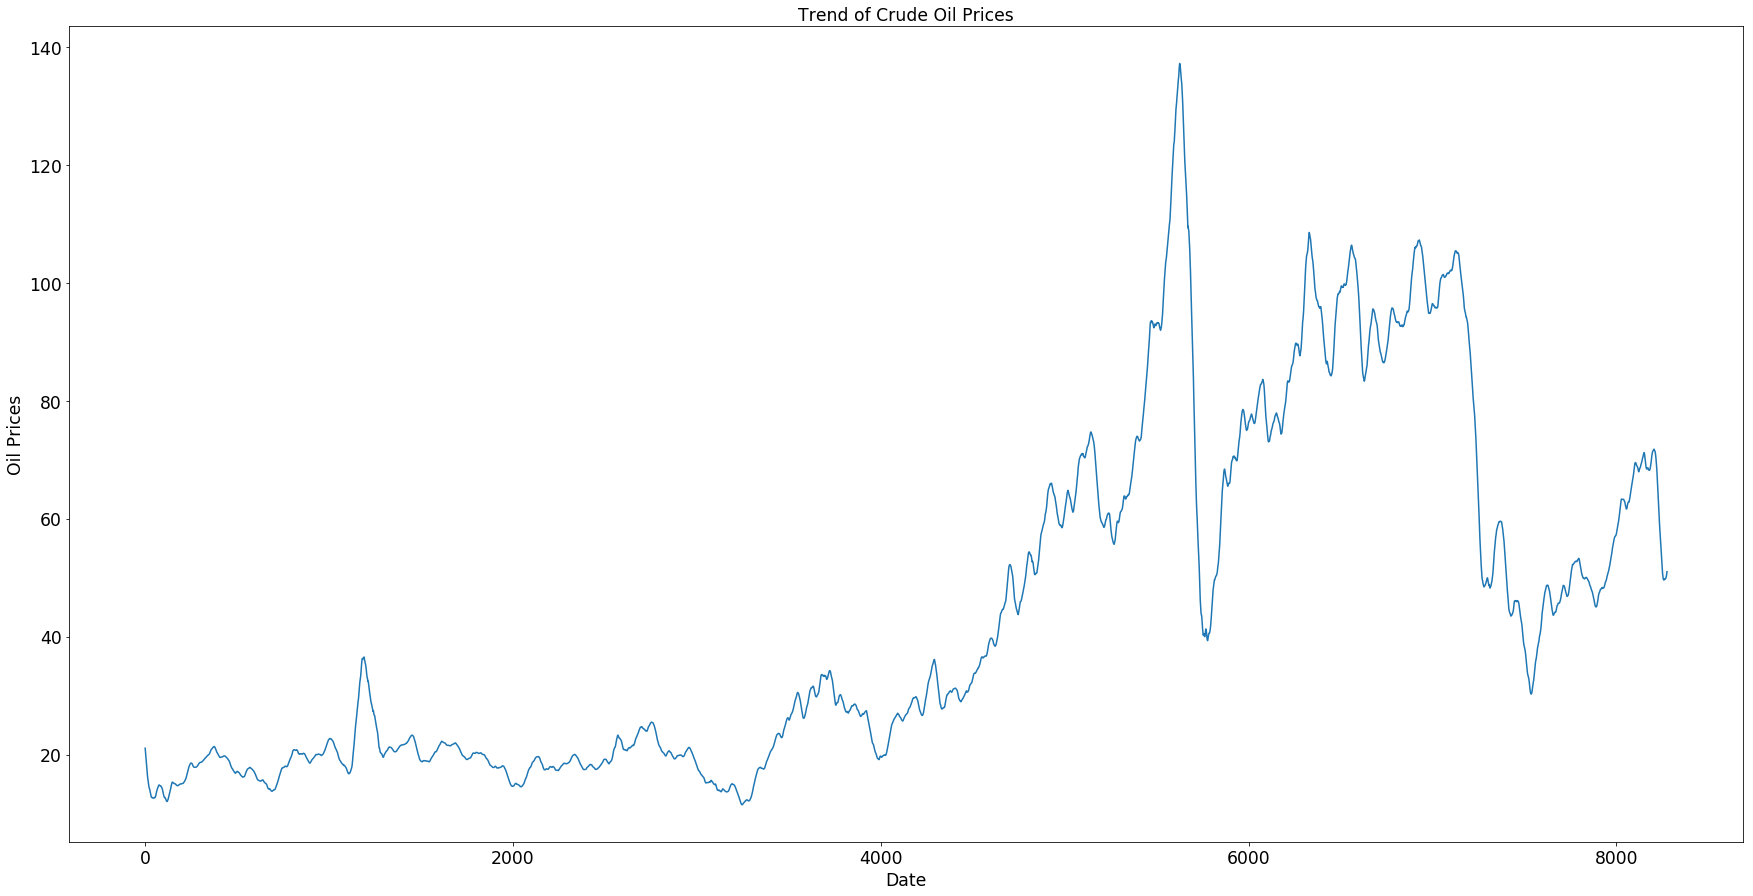

In [10]:
show_graph(averages)

# Hidden Markov Model

In [11]:
recent_trends = trends[-3000:]['DCOILWTICO'].values.astype(int).reshape(-1, 1)
remodel = hmm.MultinomialHMM(n_components=5, n_iter=200)
remodel.fit(recent_trends[:2000])
test_set = recent_trends[2000:]
predictions = remodel.predict(test_set)
accuracy = (predictions == test_set.flatten()).sum() * 100 / len(predictions)
'Accuracy for Hidden Markov Model is {}%.'.format(accuracy)

'Accuracy for Hidden Markov Model is 85.5%.'

In [12]:
scaler = MinMaxScaler(feature_range=(0,1))
matrix = scaler.fit_transform(averages[-3000:])
matrix_train = matrix[:2000]
matrix_test = matrix[2000:]
x_train, y_train, x_test, y_test = generate_train_test_prediction_windows(matrix_train, matrix_test, PREDICTION_WINDOW_SIZE)

# RNN Model

In [13]:
rnn_model, rnn_history = train_model(x_train, y_train, LSTM_UNITS, DROPOUT, NUM_LSTM_LAYERS, 'rnn', EPOCH, BATCH_SIZE)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
1950/1950 [==============================] - 5s 2ms/step - loss: 0.4277
Epoch 2/100
1950/1950 [==============================] - 4s 2ms/step - loss: 0.2523
Epoch 3/100
1950/1950 [==============================] - 4s 2ms/step - loss: 0.1679
Epoch 4/100
1950/1950 [==============================] - 4s 2ms/step - loss: 0.1171
Epoch 5/100
1950/1950 [==============================] - 4s 2ms/step - loss: 0.0822
Epoch 6/100
1950/1950 [==============================] - 4s 2ms/step - loss: 0.0556
Epoch 7/100
1950/1950 [==============================] - 4s 2ms/step - loss: 0.0358
Epoch 8/100
1950/1950 [==============================] - 4s 2ms/step - loss: 0.0255
Epoch 9/100
1950/1950 [==============================] - 4s 2ms/step - loss: 0.0184
Epoch 10/

1950/1950 [==============================] - 3s 2ms/step - loss: 8.8654e-04
Epoch 87/100
1950/1950 [==============================] - 3s 2ms/step - loss: 7.9652e-04
Epoch 88/100
1950/1950 [==============================] - 3s 2ms/step - loss: 8.8160e-04
Epoch 89/100
1950/1950 [==============================] - 4s 2ms/step - loss: 8.0477e-04
Epoch 90/100
1950/1950 [==============================] - 3s 2ms/step - loss: 7.8461e-04
Epoch 91/100
1950/1950 [==============================] - 3s 2ms/step - loss: 8.9154e-04
Epoch 92/100
1950/1950 [==============================] - 3s 1ms/step - loss: 8.1492e-04
Epoch 93/100
1950/1950 [==============================] - 3s 2ms/step - loss: 8.1919e-04
Epoch 94/100
1950/1950 [==============================] - 3s 1ms/step - loss: 7.6278e-04
Epoch 95/100
1950/1950 [==============================] - 3s 2ms/step - loss: 7.3130e-04
Epoch 96/100
1950/1950 [==============================] - 3s 2ms/step - loss: 6.6888e-04
Epoch 97/100
1950/1950 [==========

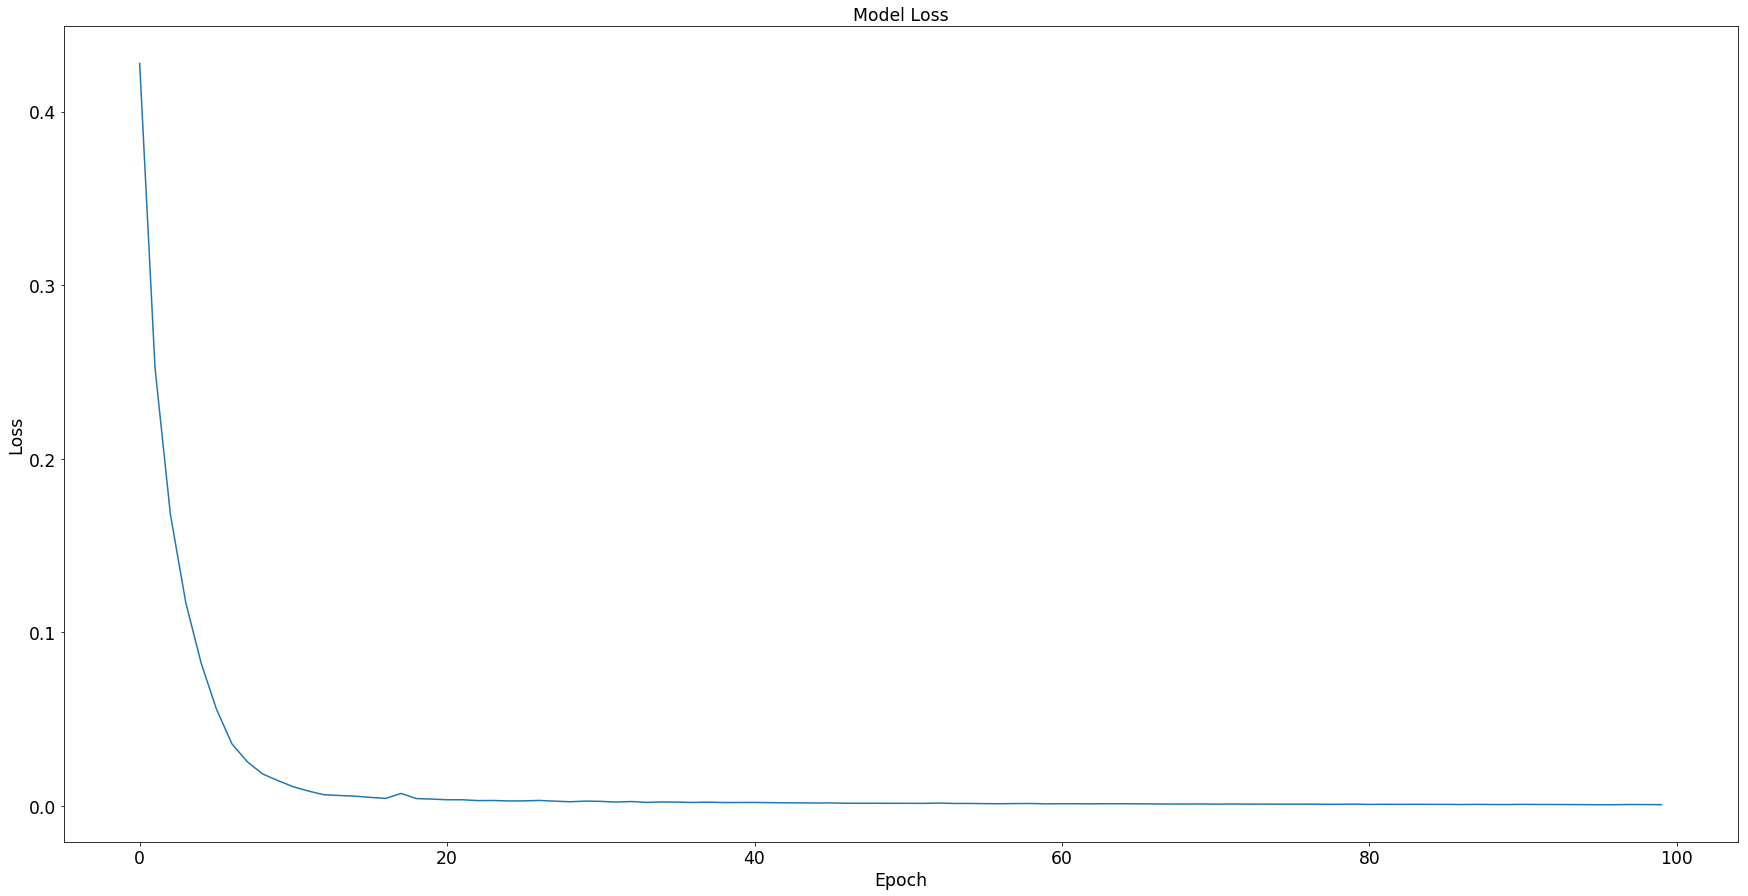

In [14]:
plot_loss(rnn_history)

# LSTM Model

In [15]:
lstm_model, lstm_history = train_model(x_train, y_train, LSTM_UNITS, DROPOUT, NUM_LSTM_LAYERS, 'lstm', EPOCH, BATCH_SIZE)

Epoch 1/100
1950/1950 [==============================] - 16s 8ms/step - loss: 0.0244
Epoch 2/100
1950/1950 [==============================] - 12s 6ms/step - loss: 0.0106
Epoch 3/100
1950/1950 [==============================] - 13s 6ms/step - loss: 0.0081
Epoch 4/100
1950/1950 [==============================] - 12s 6ms/step - loss: 0.0072
Epoch 5/100
1950/1950 [==============================] - 12s 6ms/step - loss: 0.0058
Epoch 6/100
1950/1950 [==============================] - 12s 6ms/step - loss: 0.0054
Epoch 7/100
1950/1950 [==============================] - 11s 6ms/step - loss: 0.0049
Epoch 8/100
1950/1950 [==============================] - 12s 6ms/step - loss: 0.0044
Epoch 9/100
1950/1950 [==============================] - 15s 7ms/step - loss: 0.0039
Epoch 10/100
1950/1950 [==============================] - 13s 7ms/step - loss: 0.0038
Epoch 11/100
1950/1950 [==============================] - 13s 7ms/step - loss: 0.0038
Epoch 12/100
1950/1950 [==============================] - 13s 7

1950/1950 [==============================] - 10s 5ms/step - loss: 5.4856e-04
Epoch 95/100
1950/1950 [==============================] - 9s 5ms/step - loss: 5.3683e-04
Epoch 96/100
1950/1950 [==============================] - 9s 4ms/step - loss: 5.3699e-04
Epoch 97/100
1950/1950 [==============================] - 10s 5ms/step - loss: 5.4803e-04
Epoch 98/100
1950/1950 [==============================] - 8s 4ms/step - loss: 5.4775e-04A: 1s - loss: 5
Epoch 99/100
1950/1950 [==============================] - 11s 5ms/step - loss: 4.9342e-04
Epoch 100/100
1950/1950 [==============================] - 11s 5ms/step - loss: 5.8268e-04


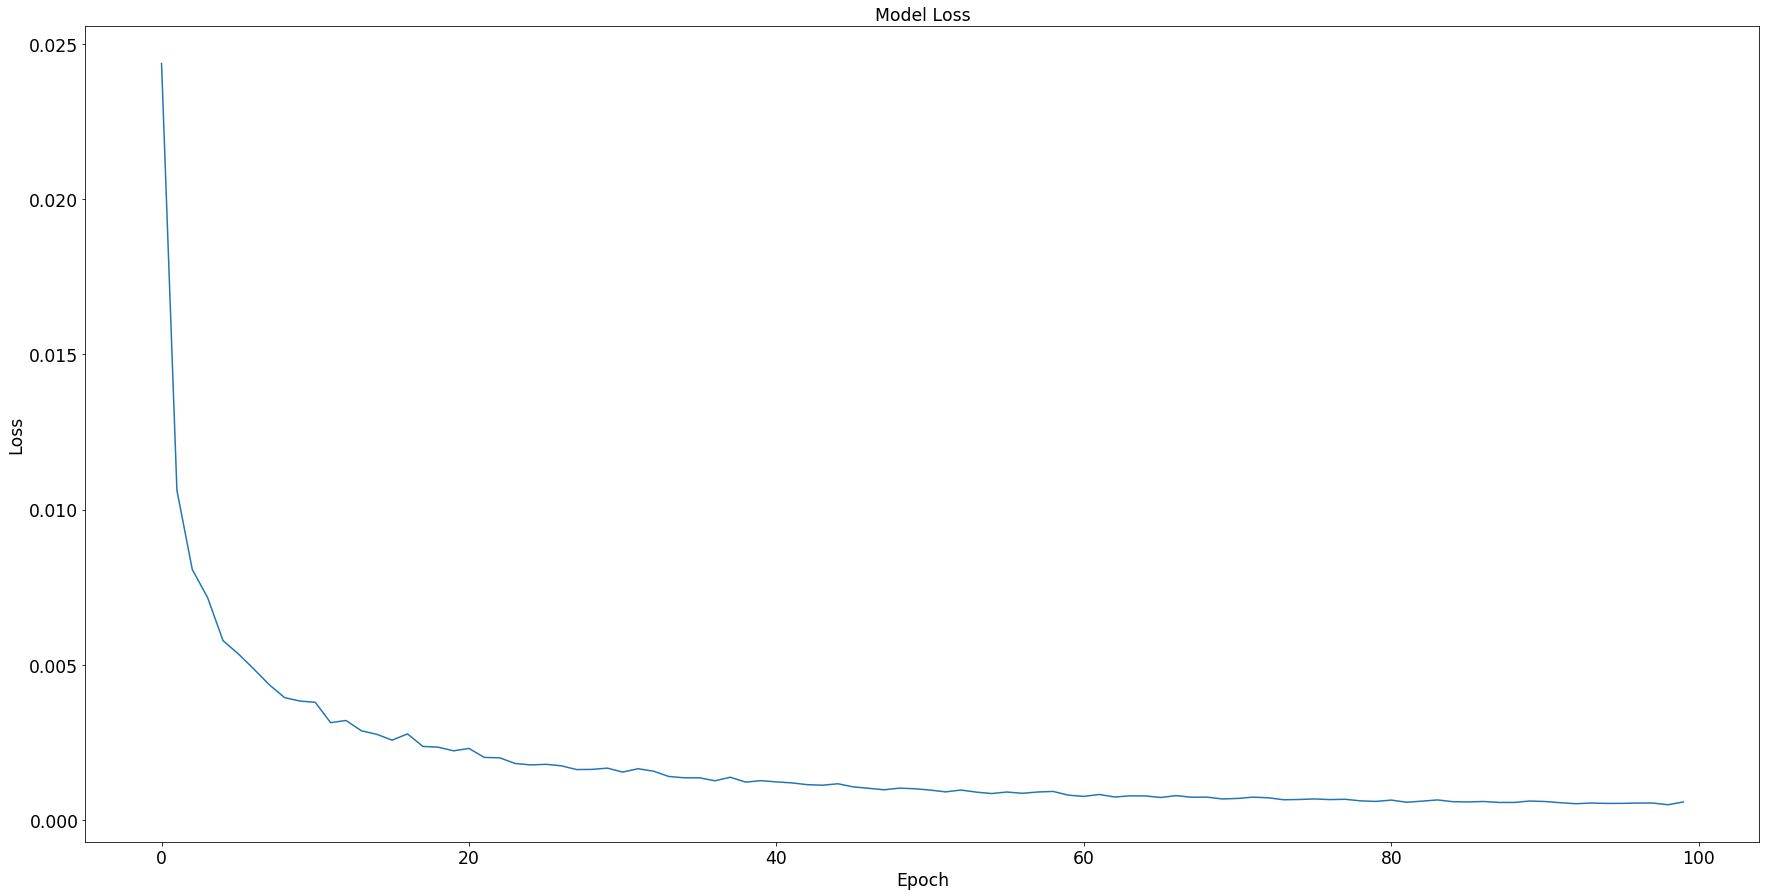

In [16]:
plot_loss(lstm_history)

# GRU Model

In [17]:
gru_model, gru_history = train_model(x_train, y_train, LSTM_UNITS, DROPOUT, NUM_LSTM_LAYERS, 'gru', EPOCH, BATCH_SIZE)

Epoch 1/100
1950/1950 [==============================] - 13s 7ms/step - loss: 0.0178
Epoch 2/100
1950/1950 [==============================] - 10s 5ms/step - loss: 0.0091
Epoch 3/100
1950/1950 [==============================] - 11s 6ms/step - loss: 0.0073
Epoch 4/100
1950/1950 [==============================] - 11s 5ms/step - loss: 0.0063
Epoch 5/100
1950/1950 [==============================] - 11s 6ms/step - loss: 0.0060
Epoch 6/100
1950/1950 [==============================] - 11s 5ms/step - loss: 0.0048
Epoch 7/100
1950/1950 [==============================] - 10s 5ms/step - loss: 0.0046
Epoch 8/100
1950/1950 [==============================] - 9s 5ms/step - loss: 0.0042
Epoch 9/100
1950/1950 [==============================] - 10s 5ms/step - loss: 0.0041
Epoch 10/100
1950/1950 [==============================] - 10s 5ms/step - loss: 0.0034
Epoch 11/100
1950/1950 [==============================] - 10s 5ms/step - loss: 0.0037
Epoch 12/100
1950/1950 [==============================] - 10s 5m

1950/1950 [==============================] - 10s 5ms/step - loss: 4.9724e-04
Epoch 95/100
1950/1950 [==============================] - 10s 5ms/step - loss: 5.5105e-04
Epoch 96/100
1950/1950 [==============================] - 10s 5ms/step - loss: 4.9527e-04
Epoch 97/100
1950/1950 [==============================] - 10s 5ms/step - loss: 4.9081e-04
Epoch 98/100
1950/1950 [==============================] - 8s 4ms/step - loss: 4.7502e-04
Epoch 99/100
1950/1950 [==============================] - 8s 4ms/step - loss: 5.0962e-04
Epoch 100/100
1950/1950 [==============================] - 8s 4ms/step - loss: 4.9676e-04


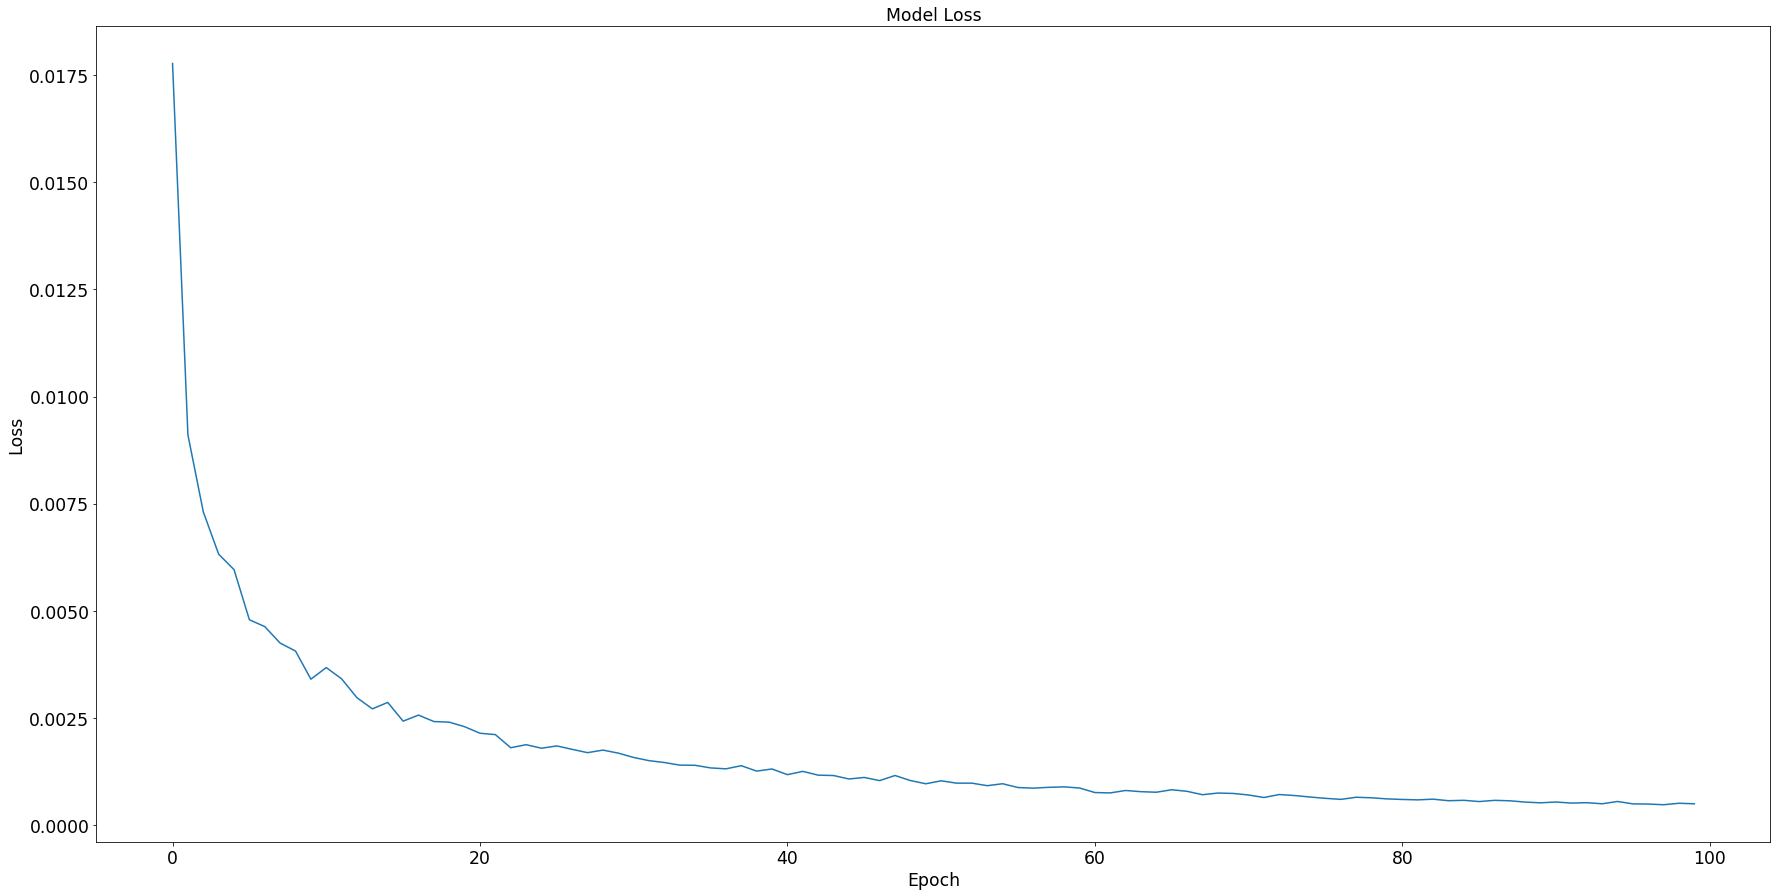

In [18]:
plot_loss(gru_history)

# Results

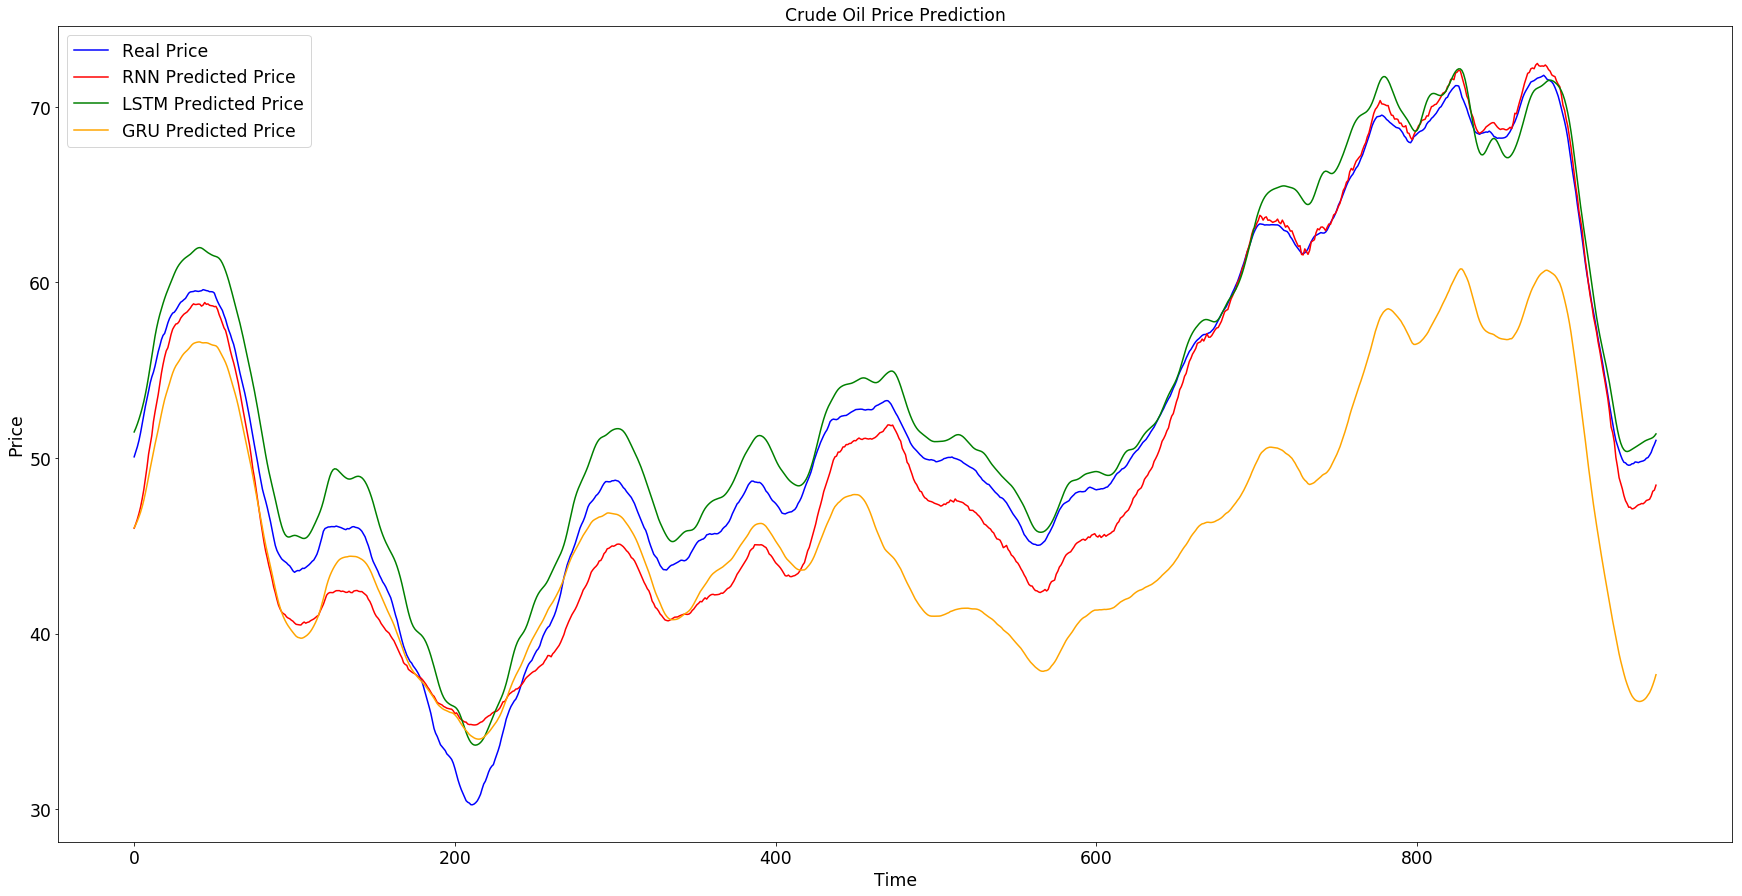

In [19]:
plot_prediction(scaler, x_test, y_test, [('RNN', rnn_model, 'red'), ('LSTM', lstm_model, 'green'), ('GRU', gru_model, 'orange')])

In [20]:
rnn_mse = calculate_mse(x_test, y_test, rnn_model)
print('Mean Square Error for RNN is {}.'.format(rnn_mse))
lstm_mse = calculate_mse(x_test, y_test, lstm_model)
print('Mean Square Error for LSTM is {}.'.format(lstm_mse))
gru_mse = calculate_mse(x_test, y_test, gru_model)
print('Mean Square Error for GRU is {}.'.format(gru_mse))

Mean Square Error for RNN is [0.00048006].
Mean Square Error for LSTM is [0.00033642].
Mean Square Error for GRU is [0.00535297].
